In [207]:
import os
import time
import uuid
import cv2

## Collecting Images Using OpenCV

In [208]:
img_path = os.path.join('data','images')
number_images = 30

In [211]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(img_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## Annotate Images with LabelMe

In [213]:
!labelme

2024-04-19 10:18:10,288 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Dell\.labelmerc


# Reviewing Dataset and Building Image Loading Function 

In [214]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## Limiting GPU Memory Growth

In [215]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Loading Image into TF Data Pipeline

In [216]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [217]:
images.as_numpy_iterator().next()

b'data\\images\\cd507e2f-fdfe-11ee-90f2-dcfb48bbbc95.jpg'

In [218]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [219]:
images = images.map(load_image)

In [220]:
images.as_numpy_iterator().next()

array([[[170, 177, 193],
        [170, 177, 193],
        [175, 178, 195],
        ...,
        [126, 117, 118],
        [126, 122, 123],
        [122, 120, 121]],

       [[172, 178, 194],
        [173, 179, 193],
        [177, 180, 195],
        ...,
        [131, 122, 123],
        [131, 127, 126],
        [127, 126, 124]],

       [[176, 179, 194],
        [178, 182, 194],
        [179, 183, 195],
        ...,
        [129, 123, 123],
        [127, 126, 124],
        [125, 126, 121]],

       ...,

       [[ 22,  26,  29],
        [ 21,  26,  29],
        [ 21,  26,  32],
        ...,
        [ 57,  51,  53],
        [ 46,  40,  44],
        [ 47,  41,  45]],

       [[ 27,  29,  28],
        [ 26,  28,  27],
        [ 22,  26,  29],
        ...,
        [ 59,  50,  53],
        [ 48,  39,  42],
        [ 47,  38,  41]],

       [[ 31,  31,  29],
        [ 27,  29,  26],
        [ 24,  25,  27],
        ...,
        [ 62,  51,  55],
        [ 50,  39,  43],
        [ 48,  37,  41]]

In [221]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## Viewing Raw Images with Matplotlib

In [222]:
img_generator = images.batch(4).as_numpy_iterator()

In [223]:
plot_images = img_generator.next()

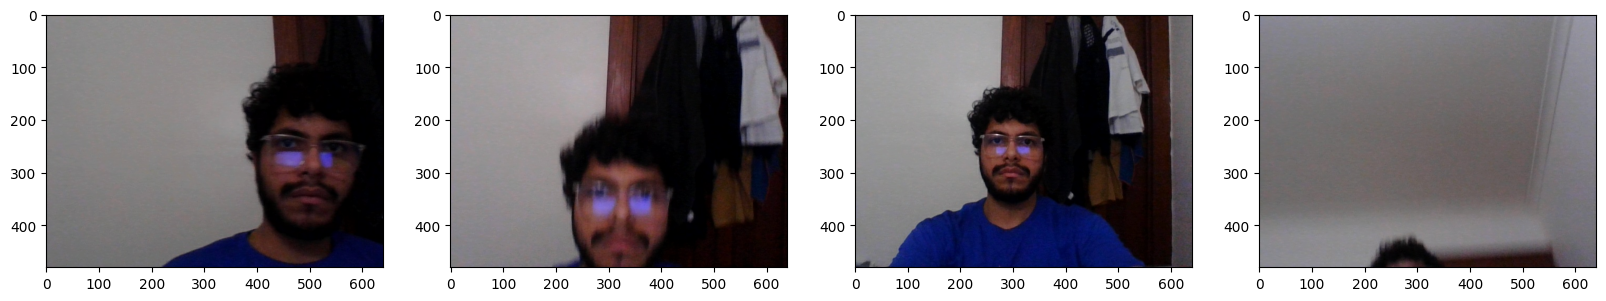

In [224]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Partitioning Unaugmented Data

## Manually splitting the data into train and test

In [225]:
90*.7 # 63 to train

62.99999999999999

In [226]:
90*.15 # 14 and 13 to test and val

13.5

## Moving the matching labels to respective folders

In [227]:
for folder in ['train','test','validation']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# Applying Image Augmentation on Images and Labels using Albumentations

## Setting up Albumentations Transform Pipeline

In [228]:
import albumentations as alb

In [193]:
img_test = cv2.imread(os.path.join('data','train', 'images','007e1be1-fdff-11ee-bd35-dcfb48bbbc95.jpg'))
img_test.shape

(480, 640, 3)

In [229]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## Loading a Test Image and Annotation with OpenCV and JSON

In [238]:
img = cv2.imread(os.path.join('data','train', 'images','007e1be1-fdff-11ee-bd35-dcfb48bbbc95.jpg'))

In [239]:
with open(os.path.join('data', 'train', 'labels', '007e1be1-fdff-11ee-bd35-dcfb48bbbc95.json'), 'r') as f:
    label = json.load(f)

In [240]:
label['shapes'][0]['points']

[[210.27777777777777, 186.11111111111111],
 [409.72222222222223, 444.44444444444446]]

## Extracting Coordinates and Rescaling to Match Image Resolution

In [241]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [242]:
coords

[210.27777777777777,
 186.11111111111111,
 409.72222222222223,
 444.44444444444446]

In [243]:
coords = list(np.divide(coords, [640,480,640,480]))

In [244]:
coords

[0.3285590277777778,
 0.3877314814814815,
 0.6401909722222222,
 0.9259259259259259]

## Applying Augmentations and Viewing Results

In [245]:
augmented_img = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [246]:
augmented_img

{'image': array([[[ 98,  21,  17],
         [ 94,  19,  13],
         [ 94,  18,  12],
         ...,
         [  2,   2,  15],
         [  3,   4,  15],
         [  4,   5,  15]],
 
        [[ 98,  21,  17],
         [ 97,  20,  16],
         [ 96,  20,  15],
         ...,
         [  1,   3,  15],
         [  2,   2,  15],
         [  4,   4,  16]],
 
        [[ 92,  20,  17],
         [ 94,  20,  15],
         [ 94,  20,  15],
         ...,
         [  1,   2,  14],
         [  1,   1,  15],
         [  2,   2,  15]],
 
        ...,
 
        [[166, 159, 161],
         [164, 157, 158],
         [164, 156, 159],
         ...,
         [ 17,  20,  44],
         [ 23,  20,  45],
         [ 23,  18,  40]],
 
        [[167, 161, 162],
         [165, 158, 159],
         [165, 157, 161],
         ...,
         [ 15,  16,  41],
         [ 15,  12,  34],
         [ 19,  14,  35]],
 
        [[165, 157, 161],
         [164, 156, 159],
         [165, 159, 162],
         ...,
         [ 18,  19,

In [247]:
augmented_img['bboxes']

[(0.07617283950617283,
  0.023456790123456805,
  0.5193827160493827,
  0.5975308641975309)]

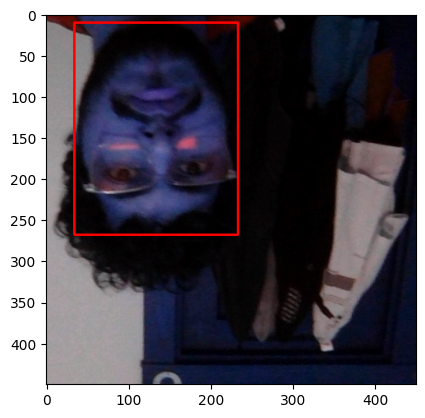

In [248]:
cv2.rectangle(augmented_img['image'], 
              tuple(np.multiply(augmented_img['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented_img['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented_img['image'])

# Build and Run Augmentation Pipeline

### Running Augmentation Pipeline

In [249]:
for partition in ['train','test','validation']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### Loading Augmented Images to Tensorflow Dataset

In [250]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [251]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [252]:
val_images = tf.data.Dataset.list_files('aug_data\\validation\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [253]:
train_images.as_numpy_iterator().next()

array([[[0.07971814, 0.01813726, 0.00238971],
        [0.09227941, 0.0161152 , 0.01384804],
        [0.10416666, 0.01427696, 0.01672794],
        ...,
        [0.65753675, 0.6536152 , 0.673223  ],
        [0.6666667 , 0.6627451 , 0.68235296],
        [0.6509804 , 0.6495098 , 0.6617647 ]],

       [[0.08762255, 0.02481618, 0.02389706],
        [0.09411765, 0.02003676, 0.02702206],
        [0.10465686, 0.02671569, 0.03455883],
        ...,
        [0.66384804, 0.6599265 , 0.6795343 ],
        [0.6661765 , 0.6622549 , 0.6818628 ],
        [0.65925246, 0.65778184, 0.6700368 ]],

       [[0.12843138, 0.05784314, 0.05      ],
        [0.13725491, 0.05882353, 0.05588235],
        [0.13946079, 0.06102941, 0.05894608],
        ...,
        [0.6612745 , 0.6573529 , 0.67696077],
        [0.65796566, 0.6540441 , 0.67365193],
        [0.6490809 , 0.6476103 , 0.6598652 ]],

       ...,

       [[0.06360294, 0.02046569, 0.00477941],
        [0.05189951, 0.01268382, 0.00484069],
        [0.04509804, 0

# Preparing Labels

### Building the Label Loading Function

In [254]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### Loading Labels to Tensorflow Dataset

In [255]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [256]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [257]:
val_labels = tf.data.Dataset.list_files('aug_data\\validation\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [258]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.283 , 0.349 , 0.726 , 0.9233], dtype=float16))

# Combining Label and Image Samples

### Checking Partition Lengths

In [259]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### Creating Final Datasets (Images/Labels)

In [260]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [261]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [262]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [263]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.2327 , 0.3691 , 0.5474 , 0.785  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2314 , 0.09753, 0.502  , 0.526  ],
        [0.2239 , 0.2654 , 0.7    , 0.8975 ],
        [0.07446, 0.1765 , 0.515  , 0.7705 ],
        [0.2847 , 0.08075, 0.739  , 0.6094 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2229 , 0.398  , 0.666  , 0.972  ]], dtype=float16))

### Viewing Images and Annotations

In [264]:
data_samples = train.as_numpy_iterator()

In [269]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


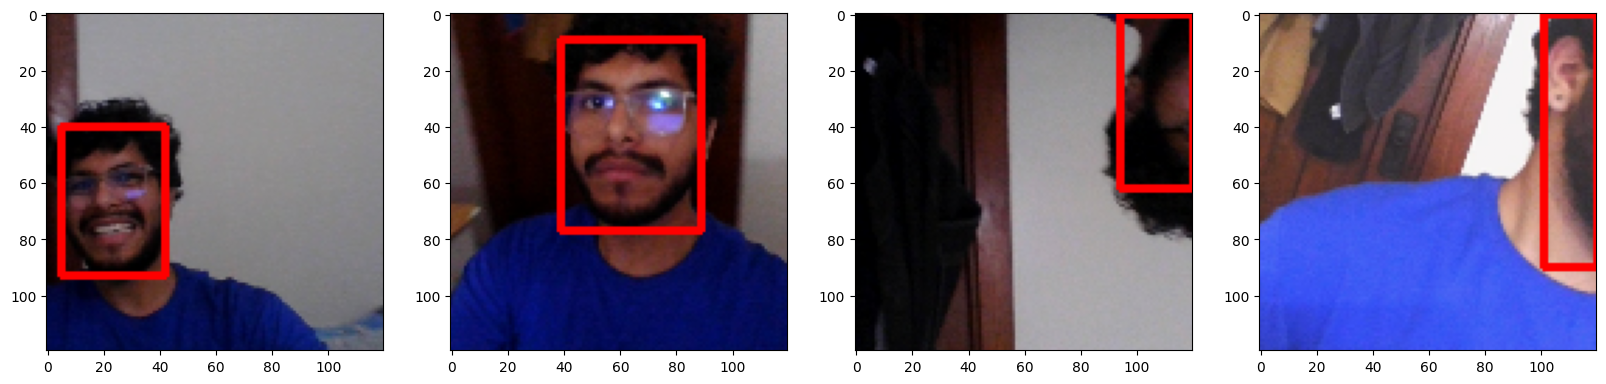

In [270]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    # Convert NumPy array to cv::UMat
    sample_image = cv2.UMat(sample_image)
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)
    
    # Convert cv::UMat back to NumPy array
    sample_image = sample_image.get()

    ax[idx].imshow(sample_image)

  # Building Deep Learning model using the Functional API

### Importing Layers and Base Network

In [271]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### Download VGG16

In [272]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Building the model

In [273]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model (regression)
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [274]:
facetracker_mod = build_model()
facetracker_mod.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │      2,049 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 4)         │      8,196 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [277]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [278]:
classes, coords = facetracker_mod.predict(X)
classes, coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


(array([[0.34013864],
        [0.4279546 ],
        [0.4221421 ],
        [0.37075064],
        [0.42085508],
        [0.36368454],
        [0.38729495],
        [0.4015193 ]], dtype=float32),
 array([[0.6511626 , 0.65258074, 0.3216581 , 0.45174557],
        [0.6854048 , 0.6509961 , 0.25060073, 0.5083776 ],
        [0.7531905 , 0.7581317 , 0.24568841, 0.50018454],
        [0.7593399 , 0.6926025 , 0.27545223, 0.40393502],
        [0.70479906, 0.660688  , 0.25427815, 0.51624954],
        [0.7089102 , 0.6788422 , 0.29493126, 0.5947242 ],
        [0.66645336, 0.6630435 , 0.36874565, 0.44540194],
        [0.7311445 , 0.66726077, 0.35064873, 0.54452527]], dtype=float32))

# Defining Losses and Optimizers

### Optimizer and learning rate

In [280]:
initial_lr = 0.0001
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [283]:
# learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, lr_decay, decay_rate=0.1, staircase=True
)

# Define the optimizer without specifying the decay argument
opt = tf.keras.optimizers.Adam(learning_rate=initial_lr)

In [284]:
opt

### Defining Localization Loss and Classification Loss

In [285]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [286]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### Testing Loss Metrics

In [287]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=11.618953>

In [288]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8571383>

In [289]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=11.618953>

# Training the Neural Network

### Creating Custom Model Class

In [312]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
                
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [313]:
nn_mod = FaceTracker(facetracker_mod)
nn_mod.compile(opt, classloss, regressloss)

### Training the model

In [314]:
logdir='logs'

In [315]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = nn_mod.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


NameError: name 'total_loss' is not defined

### Plotting Performance

In [316]:
hist.history

NameError: name 'hist' is not defined

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Making Predictions

### Making Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Saving the Model

In [317]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()